In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, RFECV, RFE
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from sklearn import metrics


In [2]:

ML_Model = []
ML_Config = []
accuracy = []
f1_score = []
recall = []
precision = []
auc_roc = []  
train_test_split_ratio = []  
# confusion_matrix = []
def storeResults(model, config, a, b, c, d, e, split_ration):
    
    ML_Model.append(model)
    ML_Config.append(config)
    accuracy.append(round(a, 6))
    f1_score.append(round(b, 6))
    recall.append(round(c, 6))
    precision.append(round(d, 6))
    auc_roc.append(round(e, 6))
    train_test_split_ratio.append(split_ration),
    # confusion_matrix.append(confusion_mtx)
    

def displayAndSaveResults(filename_prefix='model_results'):

    result = pd.DataFrame({
        'ML Model': ML_Model,
        'Configuration': ML_Config,
        'Accuracy': [f"{acc * 100:.3f}%" for acc in accuracy],
        'F1 Score': [f"{f1 * 100:.3f}%" for f1 in f1_score],
        'Recall': [f"{rec * 100:.3f}%" for rec in recall],
        'Precision': [f"{prec * 100:.3f}%" for prec in precision],
        'ROC_AUC': [f"{roc * 100:.3f}%" for roc in auc_roc],
        'Train-Test Split Ratio': train_test_split_ratio,
        # 'Confusion Matrix': confusion_matrix,
    })
    
    result.drop_duplicates(subset=["ML Model", "Configuration"], inplace=True)
    
    print("\n" + "="*100)
    print("MODEL PERFORMANCE RESULTS")
    print("="*100)
    print(result.to_string(index=False))
    
    result.to_csv(f'{filename_prefix}.csv', index=False)
    print(f"\nResults saved to {filename_prefix}.csv")
    
    sorted_result = result.sort_values(by=['Accuracy', 'F1 Score'], ascending=False).reset_index(drop=True)
    
    print("\n" + "="*100)
    print("SORTED MODEL PERFORMANCE RESULTS (by Accuracy and F1 Score)")
    print("="*100)
    print(sorted_result.to_string(index=False))
    
    sorted_result.to_csv(f'sorted_{filename_prefix}.csv', index=False)
    print(f"\nSorted results saved to sorted_{filename_prefix}.csv")
    
    return result, sorted_result

def clearResults():
    global ML_Model, ML_Config, accuracy, f1_score, recall, precision, auc_roc, train_test_split_ratio
    ML_Model.clear()
    ML_Config.clear()
    accuracy.clear()
    f1_score.clear()
    recall.clear()
    precision.clear()
    auc_roc.clear()
    train_test_split_ratio.clear()
    # confusion_matrix.clear()
    print("Results cleared!")

def plotModelComparison(result_df):
    
    metrics_cols = ['Accuracy', 'F1 Score', 'Recall', 'Precision', 'ROC_AUC']
    plot_df = result_df.copy()
    
    for col in metrics_cols:
        plot_df[col] = plot_df[col].str.rstrip('%').astype(float)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for idx, metric in enumerate(metrics_cols):
        model_performance = plot_df.groupby('ML Model')[metric].mean().sort_values(ascending=False)
        
        ax = axes[idx]
        bars = ax.bar(range(len(model_performance)), model_performance.values, 
                      color=plt.cm.Blues(np.linspace(0.4, 0.9, len(model_performance))))
        ax.set_xticks(range(len(model_performance)))
        ax.set_xticklabels(model_performance.index, rotation=45, ha='right')
        ax.set_ylabel(f'{metric} (%)')
        ax.set_title(f'Average {metric} by Model', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom')
    
    if len(metrics_cols) == 5:
        axes[5].set_visible(False)
    
    plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Model results storage framework loaded successfully!")
print("Available functions:")
print("- storeResults(model, config, accuracy, f1, recall, precision, auc_roc)")
print("- displayAndSaveResults(filename_prefix='model_results')")
print("- clearResults()")
print("- plotModelComparison(result_df)")


Model results storage framework loaded successfully!
Available functions:
- storeResults(model, config, accuracy, f1, recall, precision, auc_roc)
- displayAndSaveResults(filename_prefix='model_results')
- clearResults()
- plotModelComparison(result_df)


In [3]:
df = pd.read_csv('/home/jeremy-mboe/Documents/Kuliah/Sem3/KP/dataset/Stress_Dataset.csv')

target_col = 'Which type of stress do you primarily experience?'
y = df[target_col]

X = df.drop(columns=[target_col])

le = LabelEncoder()
y = le.fit_transform(y)

print("Stress type encoding:")
for i, class_name in enumerate(le.classes_):
    print(f"  {class_name}: {i}")

print("\nX.dtypes after processing:\n", X.dtypes)
print("\nStress type class counts:\n", pd.Series(y).value_counts().sort_index())

split_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42, stratify=y) # train coba dikurangi eksperimen
split_ratio = round((1 - split_size) * 100)
print(split_ratio)

Stress type encoding:
  Distress (Negative Stress) - Stress that causes anxiety and impairs well-being.: 0
  Eustress (Positive Stress) - Stress that motivates and enhances performance.: 1
  No Stress - Currently experiencing minimal to no stress.: 2

X.dtypes after processing:
 Gender                                                                  int64
Age                                                                     int64
Have you recently experienced stress in your life?                      int64
Have you noticed a rapid heartbeat or palpitations?                     int64
Have you been dealing with anxiety or tension recently?                 int64
Do you face any sleep problems or difficulties falling asleep?          int64
Have you been dealing with anxiety or tension recently?.1               int64
Have you been getting headaches more often than usual?                  int64
Do you get irritated easily?                                            int64
Do you have troubl

In [4]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(632, 25) (211, 25) (632,) (211,)


In [5]:
df_y_train = pd.DataFrame(y_train, columns=['Stress Type'])
df_y_test = pd.DataFrame(y_test, columns=['Stress Type'])
df_y_train.value_counts()
# df_y_test.value_counts()

Stress Type
1              576
2               32
0               24
Name: count, dtype: int64

In [6]:
df_y_test.value_counts()

Stress Type
1              192
2               11
0                8
Name: count, dtype: int64

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from flexible_pinball_loss import FPLinearPinballSVM
print(FPLinearPinballSVM.get_params)


<function BaseEstimator.get_params at 0x7ae32c298e00>


In [5]:
configurations = []
# configurations.append(('Original Data', X_train, X_test, y_train))

# Step 2: Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)
configurations.append(('Normalized Data', X_train_normalized, X_test_normalized, y_train))


In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("Before oversampling:", np.bincount(y_train))
print("After oversampling:", np.bincount(y_train_balanced))

scaler = StandardScaler()
X_train_balanced_norm = scaler.fit_transform(X_train_balanced)
X_test_norm = scaler.transform(X_test)

configurations.append(('SMOTE + Normalized Data', X_train_balanced_norm, X_test_norm, y_train_balanced))


Before oversampling: [ 24 576  32]
After oversampling: [576 576 576]


# SVM

In [ ]:
# from sklearn.base import clone
# from flexible_pinball_loss import FlexiblePinballSVM

# fp = FlexiblePinballSVM(C=1, tau1=0.5, tau2=-0.5)
# fp_clone = clone(fp)
# print(fp_clone)


FlexiblePinballSVM(C=1, tau2=-0.5)


In [14]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5, 1.0]
}

confusion_matrices_svm = []

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning SVM with {name} configuration...")
    svc = GridSearchCV(SVC(probability=True), param_grid, cv=10, n_jobs=-1, verbose=0)
    svc.fit(X_train_cfg, y_train_cfg)

    y_train_svc = svc.predict(X_train_cfg)
    y_test_svc = svc.predict(X_test_cfg)
    y_train_svc_proba = svc.predict_proba(X_train_cfg)
    y_test_svc_proba = svc.predict_proba(X_test_cfg)

    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_svc),
            metrics.accuracy_score(y_test, y_test_svc),
        ],
        "F1 Score": [
            metrics.f1_score(y_train_cfg, y_train_svc, average='macro'),
            metrics.f1_score(y_test, y_test_svc, average='macro'),
        ],
        "Recall": [
            metrics.recall_score(y_train_cfg, y_train_svc, average='macro'),
            metrics.recall_score(y_test, y_test_svc, average='macro'),
        ],
        "Precision": [
            metrics.precision_score(y_train_cfg, y_train_svc, average='macro'),
            metrics.precision_score(y_test, y_test_svc, average='macro'),
        ],
        "AUC-ROC": [
            metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_svc_proba, multi_class='ovr', average='macro'),
            metrics.roc_auc_score(pd.get_dummies(y_test), y_test_svc_proba, multi_class='ovr', average='macro'),
        ]
    }
    cm = confusion_matrix(y_test, y_test_svc)
    confusion_matrices_svm.append((name, cm, svc.best_params_))

    df_metrics = pd.DataFrame(metrics_dict)
    print("\n Normal Support Vector Machine Model Performance Metrics")
    print(df_metrics.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_svc_proba, multi_class='ovr', average='macro')
    storeResults(
        'Support Vector Machine 90',
        name,
        metrics.accuracy_score(y_test, y_test_svc),
        metrics.f1_score(y_test, y_test_svc, average='macro'),
        metrics.recall_score(y_test, y_test_svc, average='macro'),
        metrics.precision_score(y_test, y_test_svc, average='macro'),
        auc_score,
        split_ratio,
        # confusion_matrix(y_test, y_test_svc)
    )

    print("Best hyperparameters found by GridSearchCV:")
    print(svc.best_params_)



Running SVM with Normalized Data configuration...

 Normal Support Vector Machine Model Performance Metrics
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  1.000000  1.000000 1.000000   1.000000 1.000000
    Test  0.981043  0.924558 0.924558   0.924558 0.967891
Best hyperparameters found by GridSearchCV:
{'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid'}

Running SVM with SMOTE + Normalized Data configuration...

 Normal Support Vector Machine Model Performance Metrics
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  1.000000  1.000000 1.000000   1.000000 1.000000
    Test  0.943128  0.689955 0.625316   0.830556 0.977251
Best hyperparameters found by GridSearchCV:
{'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}



=== CONFUSION MATRICES FOR ALL CONFIGURATIONS ===

Normalized Data - Best Parameters: {'C': 100, 'coef0': 0.0, 'degree': 2, 'gamma': 0.01, 'kernel': 'sigmoid'}
[[  7   1   0]
 [  1 190   1]
 [  0   1  10]]


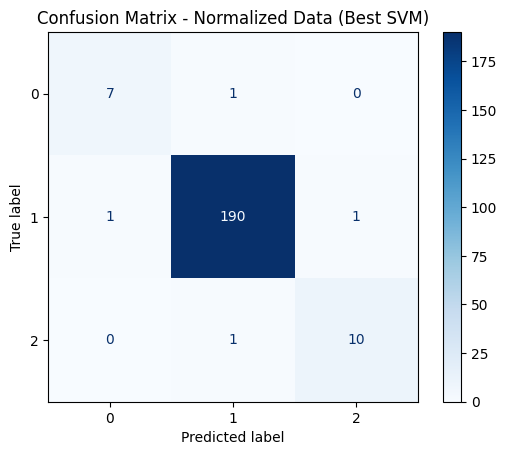


SMOTE + Normalized Data - Best Parameters: {'C': 10, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1, 'kernel': 'rbf'}
[[  2   6   0]
 [  1 190   1]
 [  0   4   7]]


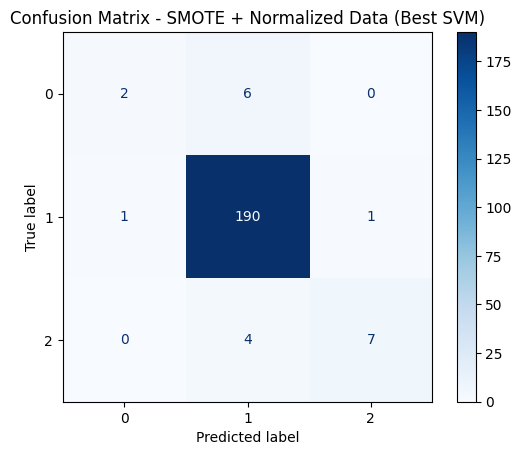

In [15]:
import matplotlib.pyplot as plt

print("\n=== CONFUSION MATRICES FOR ALL CONFIGURATIONS ===")

for name, cm, best_params in confusion_matrices_svm:
    print(f"\n{name} - Best Parameters: {best_params}")
    print(cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix - {name} (Best SVM)")
    plt.show()


# Flexible Pinball Loss SVM

In [7]:
from flexible_pinball_loss import FPLinearPinballSVM
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


In [8]:
import itertools

C_values = [0.1, 1, 10]
tau1_values = [-1.0, -0.5, 0.0, 0.5, 1.0]
tau2_values = [-1.0, -0.5, 0.0, 0.5, 1.0]

param_grid_fp = []
for C, tau1, tau2 in itertools.product(C_values, tau1_values, tau2_values):
    if -tau2 <= tau1 <= 1: 
        param_grid_fp.append({
            'estimator__C': C,
            'estimator__tau1': tau1,
            'estimator__tau2': tau2
        })

print(f"Valid hyperparameter combinations: {len(param_grid_fp)}")

Valid hyperparameter combinations: 45


In [9]:
import itertools

C_values = [0.1, 1, 10]
tau1_values = [-1.0, -0.5, 0.0, 0.5, 1.0]
tau2_values = [-1.0, -0.5, 0.0, 0.5, 1.0]

valid_tau1 = []
valid_tau2 = []

for tau1, tau2 in itertools.product(tau1_values, tau2_values):
    if -tau2 <= tau1 <= 1:
        valid_tau1.append(tau1)
        valid_tau2.append(tau2)

param_grid_fp = {
    'estimator__C': C_values,
    'estimator__tau1': list(sorted(set(valid_tau1))),
    'estimator__tau2': list(sorted(set(valid_tau2)))
}

print("Filtered tau1 values:", param_grid_fp['estimator__tau1'])
print("Filtered tau2 values:", param_grid_fp['estimator__tau2'])


Filtered tau1 values: [-1.0, -0.5, 0.0, 0.5, 1.0]
Filtered tau2 values: [-1.0, -0.5, 0.0, 0.5, 1.0]


In [10]:
confusion_matrices_fp = []

for name, X_train_cfg, X_test_cfg, y_train_cfg in configurations:
    print(f"\nRunning Flexible Pinball SVM with {name} configuration...")

    fp_base = FPLinearPinballSVM()
    fp_ovr = OneVsRestClassifier(fp_base)

    fp_grid = GridSearchCV(fp_ovr, param_grid_fp, cv=5, n_jobs=1)
    

    fp_grid.fit(X_train_cfg, y_train_cfg)

    y_train_pred = fp_grid.predict(X_train_cfg)
    y_test_pred = fp_grid.predict(X_test_cfg)

    try:
        y_train_proba = fp_grid.predict_proba(X_train_cfg)
        y_test_proba = fp_grid.predict_proba(X_test_cfg)
    except:
        y_train_proba = pd.get_dummies(y_train_pred)
        y_test_proba = pd.get_dummies(y_test_pred)

    metrics_dict = {
        "Dataset": ["Training", "Test"],
        "Accuracy": [
            metrics.accuracy_score(y_train_cfg, y_train_pred),
            metrics.accuracy_score(y_test, y_test_pred),
        ],
        "F1 Score": [
            metrics.f1_score(y_train_cfg, y_train_pred, average='macro'),
            metrics.f1_score(y_test, y_test_pred, average='macro'),
        ],
        "Recall": [
            metrics.recall_score(y_train_cfg, y_train_pred, average='macro'),
            metrics.recall_score(y_test, y_test_pred, average='macro'),
        ],
        "Precision": [
            metrics.precision_score(y_train_cfg, y_train_pred, average='macro'),
            metrics.precision_score(y_test, y_test_pred, average='macro'),
        ],
        "AUC-ROC": [
            metrics.roc_auc_score(pd.get_dummies(y_train_cfg), y_train_proba, multi_class='ovr', average='macro'),
            metrics.roc_auc_score(pd.get_dummies(y_test), y_test_proba, multi_class='ovr', average='macro'),
        ]
    }

    df_metrics_fp = pd.DataFrame(metrics_dict)
    print("\nFlexible Pinball SVM Model Performance Metrics")
    print(df_metrics_fp.to_string(index=False))

    auc_score = metrics.roc_auc_score(pd.get_dummies(y_test), y_test_proba, multi_class='ovr', average='macro')
    storeResults(
        'Flexible Pinball SVM',
        name,
        metrics.accuracy_score(y_test, y_test_pred),
        metrics.f1_score(y_test, y_test_pred, average='macro'),
        metrics.recall_score(y_test, y_test_pred, average='macro'),
        metrics.precision_score(y_test, y_test_pred, average='macro'),
        auc_score,
        split_ratio
    )
    cm_fp = confusion_matrix(y_test, y_test_pred)
    confusion_matrices_fp.append((name, cm_fp, fp_grid.best_params_))

    print("Best hyperparameters found by GridSearchCV:")
    print(fp_grid.best_params_)



Running Flexible Pinball SVM with Normalized Data configuration...


/home/jeremy-mboe/Documents/Kuliah/Sem3/Machine_Learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
150 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremy-mboe/Documents/Kuliah/Sem3/Machine_Learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremy-mboe/Documents/Kuliah/Sem3/Machine_Learning/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^


Flexible Pinball SVM Model Performance Metrics
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.971519  0.870330 0.791667   0.989899 1.000000
    Test  0.976303  0.895465 0.825758   0.991540 0.998852
Best hyperparameters found by GridSearchCV:
{'estimator__C': 1, 'estimator__tau1': 1.0, 'estimator__tau2': -1.0}

Running Flexible Pinball SVM with SMOTE + Normalized Data configuration...


/home/jeremy-mboe/Documents/Kuliah/Sem3/Machine_Learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
150 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jeremy-mboe/Documents/Kuliah/Sem3/Machine_Learning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jeremy-mboe/Documents/Kuliah/Sem3/Machine_Learning/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^


Flexible Pinball SVM Model Performance Metrics
 Dataset  Accuracy  F1 Score   Recall  Precision  AUC-ROC
Training  0.974537  0.974383 0.974537   0.975423 0.992292
    Test  0.876777  0.709392 0.886364   0.653927 0.972627
Best hyperparameters found by GridSearchCV:
{'estimator__C': 10, 'estimator__tau1': 1.0, 'estimator__tau2': -1.0}



=== CONFUSION MATRICES FOR FLEXIBLE PINBALL SVM ===

Normalized Data - Best Parameters: {'estimator__C': 1, 'estimator__tau1': 1.0, 'estimator__tau2': -1.0}
[[  6   2   0]
 [  0 192   0]
 [  0   3   8]]


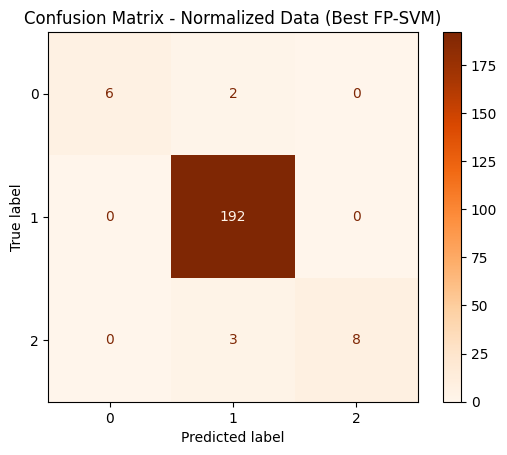


SMOTE + Normalized Data - Best Parameters: {'estimator__C': 10, 'estimator__tau1': 1.0, 'estimator__tau2': -1.0}
[[  7   1   0]
 [ 20 168   4]
 [  0   1  10]]


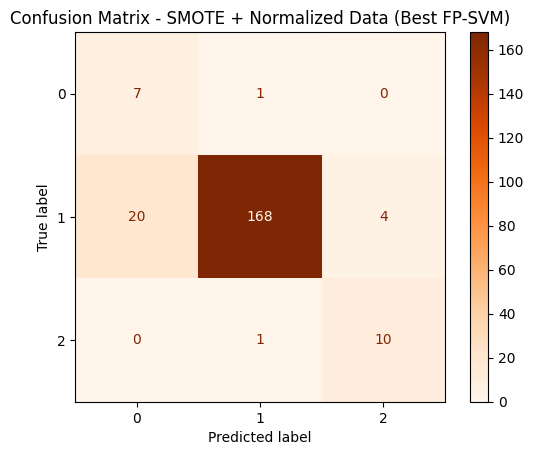

In [11]:
print("\n=== CONFUSION MATRICES FOR FLEXIBLE PINBALL SVM ===")

for name, cm_fp, best_params_fp in confusion_matrices_fp:
    print(f"\n{name} - Best Parameters: {best_params_fp}")
    print(cm_fp)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_fp,
                                  display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Oranges, values_format='d')
    plt.title(f"Confusion Matrix - {name} (Best FP-SVM)")
    plt.show()
